In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare data

In [2]:
# Nạp dữ liệu
jobs = pd.read_csv("../data/clean_data_train.csv")
jobs = jobs.drop(columns=['Sex', 'Contract Type'])
jobs.head()

,Salary,Level,Year of Experience,Programming Language,Language,Lang,Location
0,20500000.0,Nhân viên,2 năm,java,tiếng anh,vi,Hà Nội
1,36500000.0,Nhân viên,2 năm,Khác,tiếng anh,en,Hồ Chí Minh
2,22500000.0,Trưởng/Phó phòng,2 năm,Khác,Không yêu cầu,vi,Hà Nội
3,22500000.0,Trưởng nhóm,3 năm,Khác,Không yêu cầu,vi,Hà Nội
4,30000000.0,Nhân viên,3 năm,php,Không yêu cầu,vi,Hà Nội


# 2. Encoding

In [3]:
jobs_encoding = jobs.copy()

In [4]:
# Lưu lại cột Salary trước khi chuẩn hóa và phân cụm
salaries = jobs_encoding['Salary']
jobs_encoding = jobs_encoding.drop(columns=['Salary'])

In [5]:
encoder = OrdinalEncoder(categories=[['Thực tập sinh', 'Nhân viên', 'Trưởng nhóm', 'Trưởng/Phó phòng', 'Quản lý / Giám sát', 'Giám đốc']])
encoded_level = encoder.fit_transform(jobs_encoding[['Level']])
jobs_encoding['Level'] = encoded_level

In [6]:
encoder = OrdinalEncoder(categories=[['vi', 'en']])
encoded_l = encoder.fit_transform(jobs_encoding[['Lang']])
jobs_encoding['Lang'] = encoded_l

In [7]:
encoder = OrdinalEncoder(categories=[['Không yêu cầu kinh nghiệm', 'Dưới 1 năm', '1 năm', '2 năm', '3 năm', '4 năm', '5 năm', 'Trên 5 năm']])
encoded_YoE = encoder.fit_transform(jobs_encoding[['Year of Experience']])
jobs_encoding['Year of Experience'] = encoded_YoE

In [8]:
jobs.head()

,Salary,Level,Year of Experience,Programming Language,Language,Lang,Location
0,20500000.0,Nhân viên,2 năm,java,tiếng anh,vi,Hà Nội
1,36500000.0,Nhân viên,2 năm,Khác,tiếng anh,en,Hồ Chí Minh
2,22500000.0,Trưởng/Phó phòng,2 năm,Khác,Không yêu cầu,vi,Hà Nội
3,22500000.0,Trưởng nhóm,3 năm,Khác,Không yêu cầu,vi,Hà Nội
4,30000000.0,Nhân viên,3 năm,php,Không yêu cầu,vi,Hà Nội


In [9]:
#LabelEncoding
le = LabelEncoder()
for col in jobs_encoding.select_dtypes(include=['object']).columns:
    jobs_encoding[col] = le.fit_transform(jobs_encoding[col])
jobs_encoding.head()

,Level,Year of Experience,Programming Language,Language,Lang,Location
0,1.0,3.0,5,1,0.0,0
1,1.0,3.0,0,1,1.0,1
2,3.0,3.0,0,0,0.0,0
3,2.0,4.0,0,0,0.0,0
4,1.0,4.0,8,0,0.0,0


# 3. Clustering

In [10]:
jobs_clustering = pd.DataFrame(normalize(jobs_encoding,axis=0), columns=jobs_encoding.columns)
jobs_clustering.head()

,Level,Year of Experience,Programming Language,Language,Lang,Location
0,0.012660,0.015572,0.017407,0.019948,0.000000,0.000000
1,0.012660,0.015572,0.000000,0.019948,0.033691,0.020924
2,0.037981,0.015572,0.000000,0.000000,0.000000,0.000000
3,0.025321,0.020763,0.000000,0.000000,0.000000,0.000000
4,0.012660,0.020763,0.027851,0.000000,0.000000,0.000000


<Axes: >

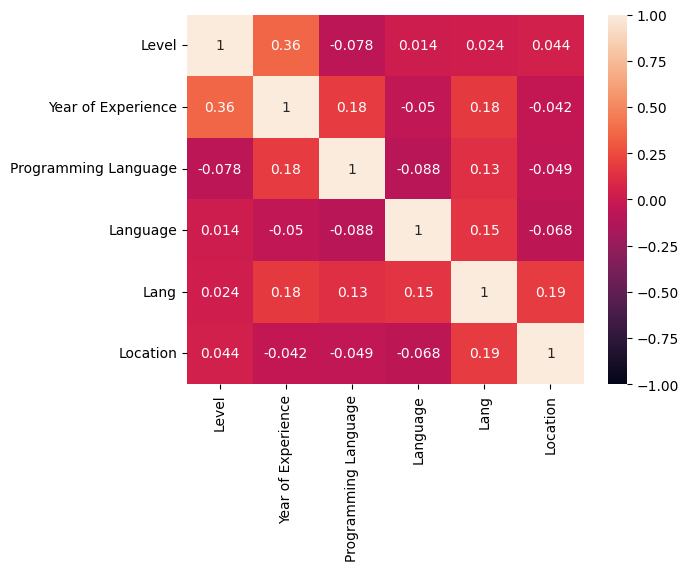

In [11]:
sns.heatmap(jobs_clustering.corr(), vmin=-1, vmax=1, annot=True)

In [12]:
# define transform
pca = PCA(n_components=2)
# prepare transform on dataset
pca.fit(jobs_clustering)
# apply transform to dataset
jobs_clustering = pca.transform(jobs_clustering)

In [13]:
def choose_K(data, K_range = range(2,9)):
    Sum_of_squared_distances = []
    K = K_range
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(data)
        Sum_of_squared_distances.append(kmeans.inertia_)

    plt.plot(K,Sum_of_squared_distances,'x-')
    plt.xlabel('Values of K')
    plt.ylabel('Sum of squared distances/Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

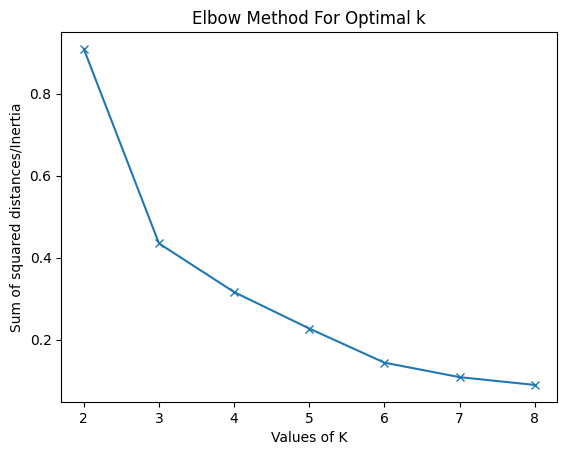

In [14]:
choose_K(jobs_clustering)

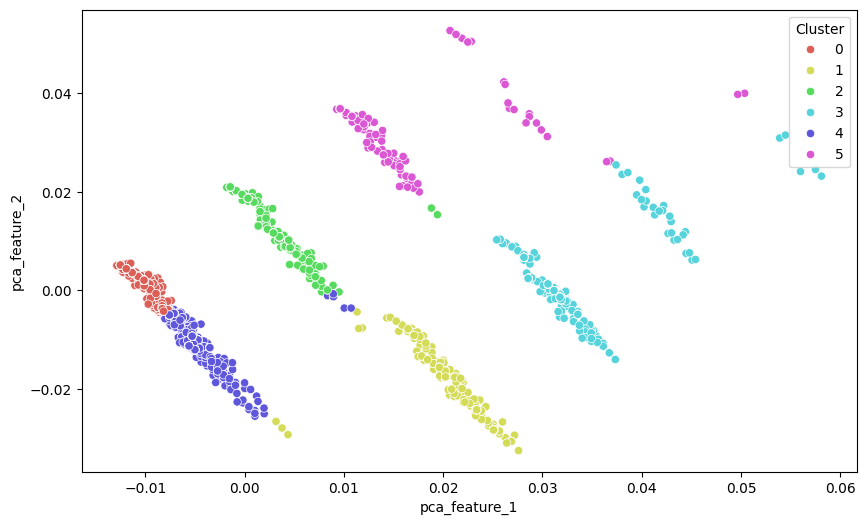

In [15]:
K = 6 #from above analysis for optimal value of k
kmeans = KMeans(n_clusters=K, init='k-means++', random_state=42)
kmeans.fit(jobs_clustering)
pred = kmeans.predict(jobs_clustering)
jobs_clustering = pd.DataFrame(jobs_clustering, columns = ['pca_feature_1','pca_feature_2']) # features selected by using PCA
jobs_clustering['Cluster'] = pred

# Plot Showing Clusters using features [2] selected from PCA
plt.figure(figsize=(10,6))
sns.scatterplot(data=jobs_clustering, x=jobs_clustering.pca_feature_1, y=jobs_clustering.pca_feature_2, hue='Cluster', palette=sns.color_palette("hls", K), legend="full")
plt.show()

In [16]:
jobs_cluster_6_means = jobs.copy()
jobs_cluster_6_means['Cluster'] = pred
jobs_cluster_6_means.to_csv('../data/k-means results/jobs_cluster_6_means.csv', index=False)

# 4. Evaluate

In [17]:
jobs_clustering

,pca_feature_1,pca_feature_2,Cluster
0,-0.004535,-0.011723,4
1,0.030693,0.000244,3
2,-0.010022,0.003076,0
3,-0.009775,0.002186,0
4,-0.005286,-0.008715,4
...,...,...,...
4968,0.028558,0.002450,3
4969,-0.011910,0.004392,0
4970,0.002915,0.011648,2
4971,0.004454,0.010216,2


# 5. Statistic

In [18]:
def define_cluster(data, cluster):
    return data[data['Cluster'] == cluster]

In [19]:
clusters = []
for i in range(K):
    clusters.append(define_cluster(jobs_cluster_6_means, i))

for i in range(K):
    clusters[i].to_csv(f'../data/k-means results/cluster_{i}.csv', index=False)
    print(f'Cluster {i}: {clusters[i].shape[0]}')

Cluster 0: 2069
Cluster 1: 439
Cluster 2: 560
Cluster 3: 444
Cluster 4: 1210
Cluster 5: 251


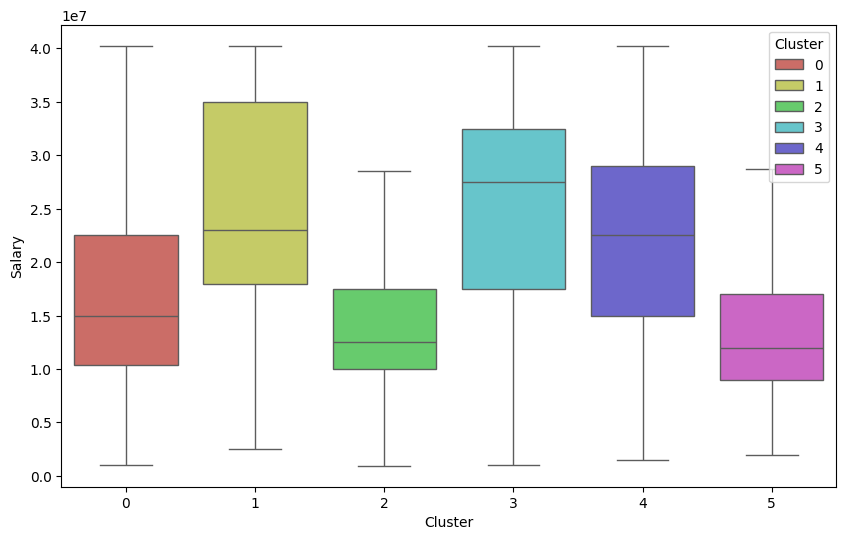

In [20]:
# Plot Salary Distribution for each Cluster
plt.figure(figsize=(10,6))
sns.boxplot(data=jobs_cluster_6_means, x='Cluster', y='Salary', hue='Cluster', palette=sns.color_palette("hls", K), showfliers=False)
plt.show()

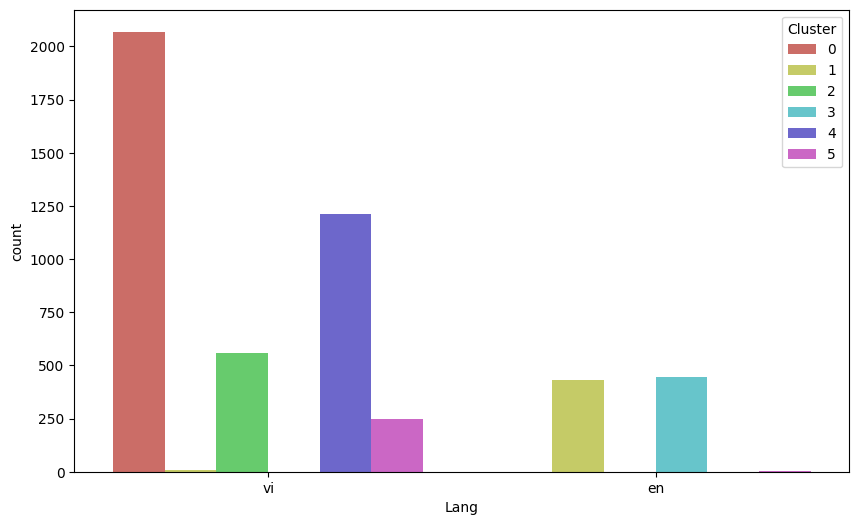

In [21]:
# Plot Lang Distribution for each Cluster
plt.figure(figsize=(10,6))
sns.countplot(data=jobs_cluster_6_means, x='Lang', hue='Cluster', palette=sns.color_palette("hls", K))
plt.show()

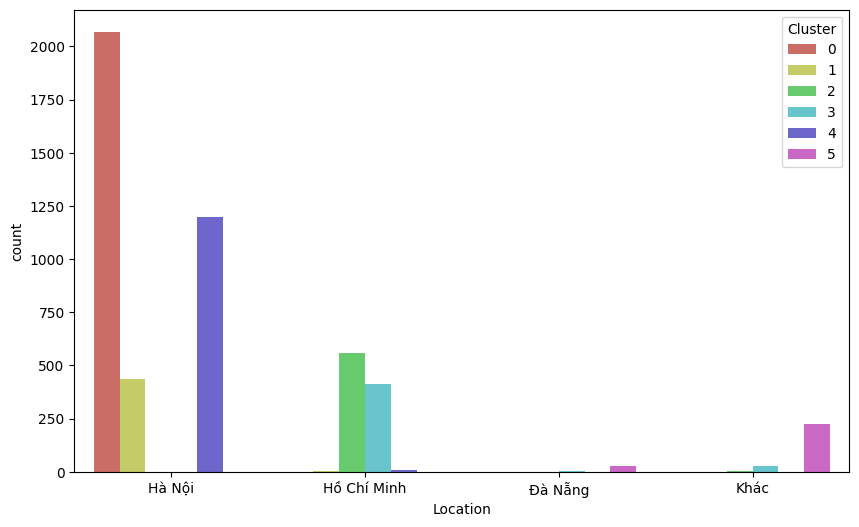

In [22]:
# Plot Location Distribution for each Cluster
plt.figure(figsize=(10,6))
sns.countplot(data=jobs_cluster_6_means, x='Location', hue='Cluster', palette=sns.color_palette("hls", K))
plt.show()